## Importamos las librerias

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import yaml
import wandb

# Cargamos el dataset y preprocesamos los datos

In [2]:
class_names = [
    'prohibitory',
    'danger',
    'mandatory',
    'other'
]

data_path = os.path.abspath('yolo_dataset_signal_types/ts/ts')
images_files = [ file_name for file_name in os.listdir( data_path ) if file_name.endswith('.jpg') ]
print( len( images_files ) )

741


## Separamos las imagenes para tener el conjunto de entrenamiento y validación

In [3]:
train_images, val_images = train_test_split( images_files, test_size = 0.2, random_state = 42 )

# Directorio de salida
output_dir = './datasets/'

train_image_list = os.path.join(output_dir, 'train_images.txt')
val_image_list = os.path.join(output_dir, 'val_images.txt')

with open(train_image_list, 'w') as f:
    for item in train_images:
        f.write("%s\n" % os.path.join(data_path, item))

with open(val_image_list, 'w') as f:
    for item in val_images:
        f.write("%s\n" % os.path.join(data_path, item))

data = {
    'train': train_image_list,
    'val': val_image_list,
    'number_classes': len(class_names),
    'names': {i: name for i, name in enumerate(class_names)}
}

yaml_file = 'dataset.yaml'
with open(yaml_file, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

## Visualizamos los datos contenidos en el dataset

In [4]:
def generate_random_colors(num_classes):
    colors = []
    for _ in range(num_classes):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors.append(color)
    return colors

In [5]:
def plot_images_with_bboxes(image_paths, data_dir, class_names, colors):
    fig, axes = plt.subplots(4, 2, figsize=(22, 27))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(image_paths):
        img_path = os.path.join(data_dir, img_file)
        label_path = os.path.join(data_dir, img_file.replace('.jpg', '.txt'))
        
        # Leer la imagen
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Leer los labels file y plotear bounding boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convertir coordenadas normalizadas a coordenadas de imagen
                    img_height, img_width, _ = image.shape
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
                    
                    # Calcular las coordenadas de los bounding boxes
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    
                    # Dibujar los bounding boxes
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[class_id], 2)
                    
                    # Agregar el label de la clase
                    label = class_names[class_id]
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 6,4)
                    label_ymin = max(y_min, label_size[1] + 10)
                    cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

        # Plotear la imagen
        axes[idx].imshow(image)
        axes[idx].axis('off')

    plt.show()

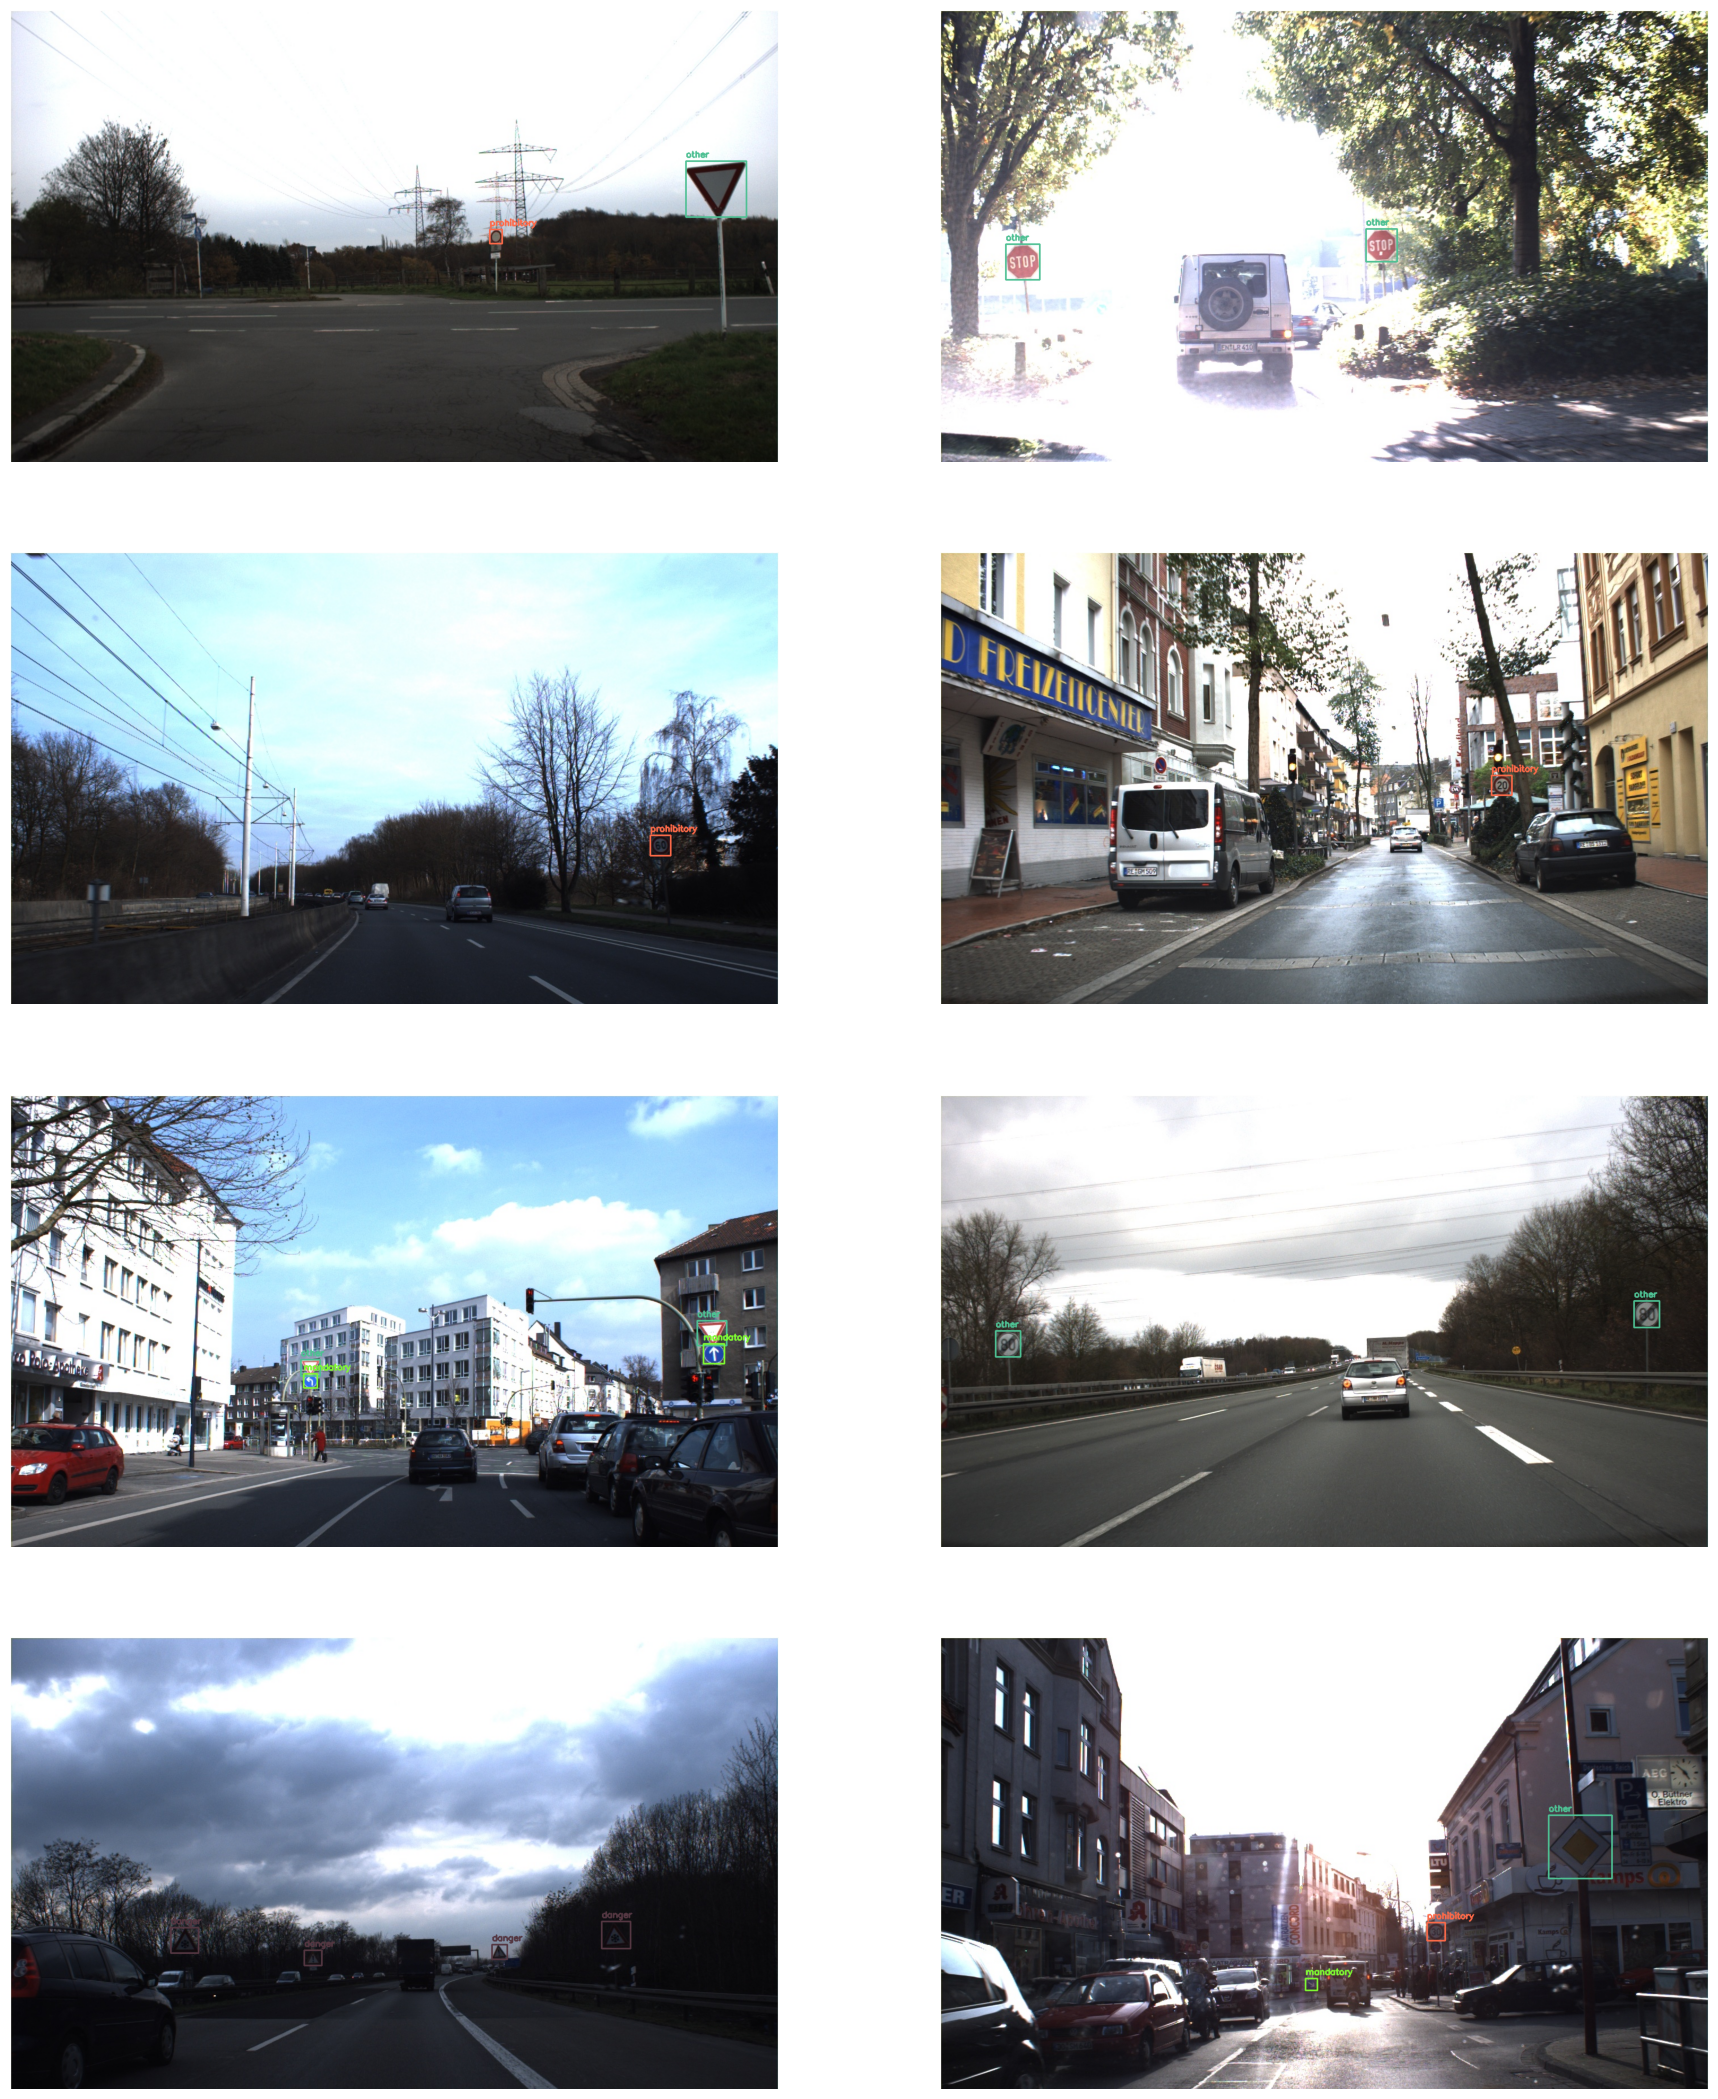

In [6]:
sampled_images = random.sample(images_files, 8)

# Generamos colores aleatorios para cada clase
colors = generate_random_colors(len(class_names))

plot_images_with_bboxes(sampled_images, data_path, class_names, colors)

## Verificamos el numero de instancias para cada clase

In [7]:
class_instance_counts = { class_id: 0 for class_id in range( len( class_names ) ) }

## Obtenemos la lista del label files
label_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]

## Contamos el numero de instancia por cada clase
for label_file in label_files:

    label_path = os.path.join(data_path, label_file)
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            class_instance_counts[class_id] += 1

## Extraemos los nombres y la cantidad de cada clase y la ploteamos

class_ids = list(class_instance_counts.keys())
instance_counts = pd.Series((class_instance_counts.values()),name="counts")
class_labels = pd.Series([class_names[class_id] for class_id in class_ids],name="class")

df = pd.concat([class_labels,instance_counts],axis=1)

iplot(px.bar(data_frame = df,x ="class",y="counts",color_discrete_sequence=px.colors.sequential.algae\
             ,title="Number of instances of each class",template="plotly_dark"))


In [8]:
wandb.login(key="bfc39c0b4b62d3893176e8c62433782275646cb9")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\juanb\_netrc


True

## Cargamos el modelo

In [11]:
model = YOLO("yolov8n.pt")

 ## Configuramos el modelo

In [12]:
results = model.train(
    data="dataset.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
)

New https://pypi.org/project/ultralytics/8.3.3 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103  Python-3.12.6 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

wandb: Currently logged in as: mhernandezl1605 (mhernandezl1605-instituto-polit-cnico-nacional). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning c:\TT\Models\OpenDrive_vision_models\yolo_dataset_signal_types\ts\ts... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<00:00, 802.06it/s]

train: New cache created: c:\TT\Models\OpenDrive_vision_models\yolo_dataset_signal_types\ts\ts.cache



val: Scanning c:\TT\Models\OpenDrive_vision_models\yolo_dataset_signal_types\ts\ts... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 507.40it/s]

val: WARNING  c:\TT\Models\OpenDrive_vision_models\yolo_dataset_signal_types\ts\ts\00340.jpg: 1 duplicate labels removed
val: New cache created: c:\TT\Models\OpenDrive_vision_models\yolo_dataset_signal_types\ts\ts.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G       1.38      6.008     0.9843         34        640:   3%|▎         | 1/37 [00:09<05:31,  9.20s/it]

100%|██████████| 755k/755k [00:00<00:00, 6.16MB/s]
      1/100         0G      1.395      4.399     0.9226         43        640: 100%|██████████| 37/37 [04:10<00:00,  6.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]

                   all        149        240    0.00095      0.149    0.00688    0.00502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.181      2.578     0.8684         39        640: 100%|██████████| 37/37 [03:09<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]

                   all        149        240      0.888     0.0556      0.448      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.121      2.025     0.8785         31        640: 100%|██████████| 37/37 [03:24<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

                   all        149        240      0.905      0.495       0.73      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.104      1.697     0.8837         39        640: 100%|██████████| 37/37 [02:46<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]

                   all        149        240      0.897      0.714      0.824      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.074      1.458     0.8595         37        640: 100%|██████████| 37/37 [04:51<00:00,  7.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

                   all        149        240      0.858      0.763      0.829      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.013       1.34     0.8497         40        640: 100%|██████████| 37/37 [06:06<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.62s/it]

                   all        149        240      0.875      0.737      0.844      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.9758      1.138       0.85         34        640: 100%|██████████| 37/37 [06:06<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]

                   all        149        240      0.909      0.762      0.869       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.9444      1.093     0.8519         53        640: 100%|██████████| 37/37 [36:41<00:00, 59.49s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240       0.91      0.786      0.886       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.9211     0.9944     0.8444         61        640: 100%|██████████| 37/37 [02:36<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]

                   all        149        240      0.954      0.812      0.899      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.9227     0.9235     0.8408         60        640: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]

                   all        149        240      0.862      0.809      0.881      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.8848     0.8399     0.8422         30        640: 100%|██████████| 37/37 [02:33<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]

                   all        149        240      0.891      0.807      0.885      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.9085     0.8316     0.8408         46        640: 100%|██████████| 37/37 [05:01<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.63s/it]

                   all        149        240      0.928      0.805      0.903      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.8939     0.7978     0.8328         42        640: 100%|██████████| 37/37 [04:22<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]

                   all        149        240      0.924       0.83      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.8562     0.7399     0.8318         38        640: 100%|██████████| 37/37 [04:25<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]

                   all        149        240      0.892      0.841      0.921      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.8774     0.7221     0.8329         37        640: 100%|██████████| 37/37 [05:44<00:00,  9.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.73s/it]

                   all        149        240      0.957       0.79      0.897      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      0.859     0.7021     0.8288         43        640: 100%|██████████| 37/37 [06:23<00:00, 10.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]

                   all        149        240      0.936      0.823      0.923      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      0.818     0.6466     0.8226         49        640: 100%|██████████| 37/37 [05:53<00:00,  9.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

                   all        149        240       0.94      0.871      0.935      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.8358     0.6447     0.8213         44        640: 100%|██████████| 37/37 [03:29<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

                   all        149        240      0.931      0.863      0.937      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.8117     0.6202     0.8281         50        640: 100%|██████████| 37/37 [03:29<00:00,  5.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

                   all        149        240      0.933      0.849      0.932      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.8095     0.6158     0.8195         55        640: 100%|██████████| 37/37 [03:25<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

                   all        149        240      0.917      0.868      0.932      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.8113     0.6026     0.8187         46        640: 100%|██████████| 37/37 [03:26<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]

                   all        149        240      0.892      0.867      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.8026     0.5896     0.8225         27        640: 100%|██████████| 37/37 [03:24<00:00,  5.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

                   all        149        240      0.942       0.87      0.937      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.8188     0.5911     0.8205         40        640: 100%|██████████| 37/37 [03:27<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

                   all        149        240      0.944      0.878      0.952      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.7842      0.567      0.817         58        640: 100%|██████████| 37/37 [03:27<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]

                   all        149        240      0.973      0.835      0.933      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.7807      0.548     0.8166         42        640: 100%|██████████| 37/37 [04:32<00:00,  7.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.73s/it]

                   all        149        240      0.905      0.868      0.938      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      0.796     0.5646     0.8089         53        640: 100%|██████████| 37/37 [03:19<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

                   all        149        240      0.947      0.828       0.93      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.7881     0.5658     0.8205         45        640: 100%|██████████| 37/37 [03:02<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]

                   all        149        240      0.928      0.871      0.943      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      0.749     0.5422     0.8168         48        640: 100%|██████████| 37/37 [03:00<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

                   all        149        240      0.931       0.88      0.932      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.7628     0.5264     0.8082         35        640: 100%|██████████| 37/37 [03:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]

                   all        149        240      0.961      0.842      0.943      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.7506      0.517      0.818         57        640: 100%|██████████| 37/37 [02:32<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

                   all        149        240      0.958      0.828      0.926      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.7377     0.5153     0.8132         39        640: 100%|██████████| 37/37 [1:00:47<00:00, 98.58s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]

                   all        149        240      0.924      0.879      0.937      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.7645     0.5256     0.8163         48        640: 100%|██████████| 37/37 [05:13<00:00,  8.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]

                   all        149        240      0.943      0.872      0.942      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      0.721     0.5103     0.8141         42        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]

                   all        149        240      0.958      0.897      0.951      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.7307     0.5084     0.8059         40        640: 100%|██████████| 37/37 [02:37<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]

                   all        149        240      0.952      0.879      0.933      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.7295     0.4959     0.8119         43        640: 100%|██████████| 37/37 [02:32<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]

                   all        149        240      0.925      0.883      0.938      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.7584     0.5166     0.8073         40        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

                   all        149        240      0.935      0.873      0.947      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.7076     0.4739     0.8003         47        640: 100%|██████████| 37/37 [02:21<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

                   all        149        240      0.908      0.886      0.948      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.7055     0.4757     0.8153         59        640: 100%|██████████| 37/37 [03:21<00:00,  5.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all        149        240      0.912      0.937      0.962      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.7525     0.5039     0.8095         46        640: 100%|██████████| 37/37 [02:42<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

                   all        149        240       0.92      0.888      0.949      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.6846      0.444     0.8098         43        640: 100%|██████████| 37/37 [04:04<00:00,  6.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]

                   all        149        240      0.916      0.893      0.955      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.6973     0.4551     0.8101         43        640: 100%|██████████| 37/37 [03:15<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]

                   all        149        240      0.938      0.834      0.941      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.6986     0.4569     0.8021         53        640: 100%|██████████| 37/37 [06:12<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.36s/it]

                   all        149        240      0.921      0.921      0.957      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      0.697     0.4591     0.8006         43        640: 100%|██████████| 37/37 [06:04<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]

                   all        149        240      0.922        0.9      0.939      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.6978     0.4526     0.8071         66        640: 100%|██████████| 37/37 [06:06<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]

                   all        149        240      0.935      0.904      0.955      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.7048     0.4583     0.8013         39        640: 100%|██████████| 37/37 [06:09<00:00,  9.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]

                   all        149        240      0.927      0.927      0.957      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.6859     0.4422     0.8023         53        640: 100%|██████████| 37/37 [35:15<00:00, 57.17s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]

                   all        149        240      0.962      0.881      0.958      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.6767     0.4427     0.8045         40        640: 100%|██████████| 37/37 [05:36<00:00,  9.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.38s/it]

                   all        149        240      0.944      0.912      0.962      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.6828     0.4335     0.8049         45        640: 100%|██████████| 37/37 [06:07<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.38s/it]

                   all        149        240       0.95      0.885       0.95      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.6429     0.4178     0.8003         55        640: 100%|██████████| 37/37 [06:05<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]

                   all        149        240      0.966      0.888      0.949      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.6762     0.4376      0.803         53        640: 100%|██████████| 37/37 [04:58<00:00,  8.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.38s/it]

                   all        149        240      0.936      0.894      0.949      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.6422     0.4219     0.7954         37        640: 100%|██████████| 37/37 [06:13<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all        149        240      0.936      0.875      0.951      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G       0.67     0.4258     0.7977         51        640: 100%|██████████| 37/37 [06:16<00:00, 10.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]

                   all        149        240      0.936      0.908      0.954      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.6715     0.4238     0.8012         43        640: 100%|██████████| 37/37 [03:57<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

                   all        149        240      0.947      0.872      0.948       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.6546     0.4159     0.8072         46        640: 100%|██████████| 37/37 [02:32<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240       0.94      0.896      0.948      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.6362     0.4032     0.8054         41        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]

                   all        149        240      0.945      0.894      0.958      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.6763     0.4202     0.8035         44        640: 100%|██████████| 37/37 [02:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

                   all        149        240       0.95      0.892      0.955      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.6331      0.405     0.8023         42        640: 100%|██████████| 37/37 [02:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]

                   all        149        240      0.927      0.917      0.961       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.6158     0.3927     0.8022         53        640: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

                   all        149        240      0.937      0.914      0.954      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.6725     0.4117     0.8019         39        640: 100%|██████████| 37/37 [04:41<00:00,  7.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

                   all        149        240      0.956      0.885      0.946      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.6594      0.411     0.7991         42        640: 100%|██████████| 37/37 [06:10<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]

                   all        149        240      0.957      0.875      0.941      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.6395     0.3992     0.7884         32        640: 100%|██████████| 37/37 [06:06<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

                   all        149        240      0.966      0.902      0.951      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.6055     0.3953     0.8004         43        640: 100%|██████████| 37/37 [06:11<00:00, 10.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all        149        240      0.971      0.909      0.959      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.6177     0.3905     0.7938         53        640: 100%|██████████| 37/37 [06:14<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]

                   all        149        240      0.951      0.883      0.958       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.6188     0.3805        0.8         51        640: 100%|██████████| 37/37 [06:09<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]

                   all        149        240      0.952      0.915      0.959      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      0.625      0.386     0.7949         55        640: 100%|██████████| 37/37 [06:11<00:00, 10.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.34s/it]

                   all        149        240      0.963      0.884      0.954      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.6475     0.3903      0.803         45        640: 100%|██████████| 37/37 [06:09<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]

                   all        149        240       0.97      0.876      0.954      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.6156     0.3861     0.7946         39        640: 100%|██████████| 37/37 [35:42<00:00, 57.90s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]

                   all        149        240      0.942      0.925       0.96      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.6062     0.3705     0.8015         51        640: 100%|██████████| 37/37 [22:35<00:00, 36.62s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.972      0.886      0.957      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.5935     0.3658     0.7954         57        640: 100%|██████████| 37/37 [02:42<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

                   all        149        240      0.958       0.88       0.95       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      0.617     0.3784     0.7919         51        640: 100%|██████████| 37/37 [03:28<00:00,  5.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

                   all        149        240      0.959      0.876      0.952      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.5931     0.3678     0.7958         48        640: 100%|██████████| 37/37 [02:33<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]

                   all        149        240       0.96       0.92      0.958      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.6061     0.3811     0.7981         62        640: 100%|██████████| 37/37 [02:42<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]

                   all        149        240      0.966      0.904      0.961      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.6009     0.3678     0.7894         44        640: 100%|██████████| 37/37 [02:34<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]

                   all        149        240      0.949      0.909       0.96      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.5784     0.3617     0.7858         47        640: 100%|██████████| 37/37 [03:22<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]

                   all        149        240      0.986      0.875      0.963      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.5665     0.3443     0.7887         56        640: 100%|██████████| 37/37 [02:40<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240       0.98      0.869      0.959      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.5643      0.347      0.788         46        640: 100%|██████████| 37/37 [5:35:06<00:00, 543.42s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.37s/it]

                   all        149        240      0.932      0.928       0.96      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.5797     0.3511     0.8031         34        640: 100%|██████████| 37/37 [06:02<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]

                   all        149        240      0.952      0.906      0.957      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.5562     0.3431     0.7882         36        640: 100%|██████████| 37/37 [53:23<00:00, 86.59s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]

                   all        149        240      0.952      0.887      0.954      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.5872     0.3581     0.7975         43        640: 100%|██████████| 37/37 [02:29<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240       0.99      0.863      0.957      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.5855     0.3519       0.79         43        640: 100%|██████████| 37/37 [6:03:04<00:00, 588.77s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.75s/it]

                   all        149        240      0.978      0.868      0.948      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5627     0.3369     0.7926         45        640: 100%|██████████| 37/37 [12:13<00:00, 19.82s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]

                   all        149        240      0.972      0.867      0.953      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.5924     0.3522     0.7956         49        640: 100%|██████████| 37/37 [03:03<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]

                   all        149        240      0.987      0.863      0.959      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.5651     0.3418      0.795         44        640: 100%|██████████| 37/37 [03:01<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]

                   all        149        240      0.958      0.886      0.958      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.5566     0.3376     0.7959         30        640: 100%|██████████| 37/37 [03:05<00:00,  5.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]

                   all        149        240      0.979      0.866      0.955      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      0.544     0.3284     0.7883         46        640: 100%|██████████| 37/37 [02:52<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

                   all        149        240      0.989       0.87      0.958      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      0.554     0.3351     0.7901         39        640: 100%|██████████| 37/37 [02:45<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.977      0.878      0.955      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.5593     0.3316     0.7883         59        640: 100%|██████████| 37/37 [03:08<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

                   all        149        240      0.979        0.9      0.962      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.5642     0.3323     0.8023         53        640: 100%|██████████| 37/37 [02:44<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]

                   all        149        240       0.96       0.92      0.961      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.5659     0.3301     0.7866         39        640: 100%|██████████| 37/37 [03:11<00:00,  5.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

                   all        149        240      0.972       0.89      0.954      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.5342     0.3254     0.7893         50        640: 100%|██████████| 37/37 [02:54<00:00,  4.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]

                   all        149        240      0.956      0.905      0.955      0.784


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.5708     0.3308     0.7799         21        640: 100%|██████████| 37/37 [03:38<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

                   all        149        240      0.978      0.872       0.95      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.535      0.315      0.778         21        640: 100%|██████████| 37/37 [03:30<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]

                   all        149        240      0.962      0.885      0.946      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.5271     0.3055     0.7756         23        640: 100%|██████████| 37/37 [03:18<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]

                   all        149        240      0.965      0.887      0.944      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.5188     0.3169     0.7884         25        640: 100%|██████████| 37/37 [03:07<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

                   all        149        240      0.942      0.922      0.952      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.5096     0.3029     0.7815         24        640: 100%|██████████| 37/37 [02:44<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]

                   all        149        240      0.977      0.856       0.95      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      0.508     0.3066     0.7856         22        640: 100%|██████████| 37/37 [02:38<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]

                   all        149        240      0.966      0.865      0.951      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.5015     0.3032     0.7771         25        640: 100%|██████████| 37/37 [02:48<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]

                   all        149        240      0.964      0.869      0.955      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      0.512     0.2991     0.7831         23        640: 100%|██████████| 37/37 [02:21<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]

                   all        149        240       0.92      0.908      0.953      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.4874     0.2931      0.781         24        640: 100%|██████████| 37/37 [18:33<00:00, 30.09s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.89s/it]

                   all        149        240      0.962      0.869      0.952      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.4921     0.2894     0.7854         21        640: 100%|██████████| 37/37 [03:28<00:00,  5.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

                   all        149        240      0.952       0.89      0.953      0.802



100 epochs completed in 22.519 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.103  Python-3.12.6 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


                   all        149        240      0.963      0.869      0.952      0.806
           prohibitory         74        110      0.977      0.973      0.993       0.86
                danger         42         54      0.987      0.944      0.984      0.867
             mandatory         22         23      0.909      0.739      0.877      0.728
                 other         40         53      0.978       0.82      0.954      0.768
Speed: 0.9ms preprocess, 45.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train2
